In [151]:
import tensorflow as tf
from tensorflow.keras import models, layers
#from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

In [152]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 4
EPOCHS = 50

In [153]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 4188 files belonging to 4 classes.


In [154]:
class_names = dataset.class_names
class_names

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [155]:
len(dataset)

131

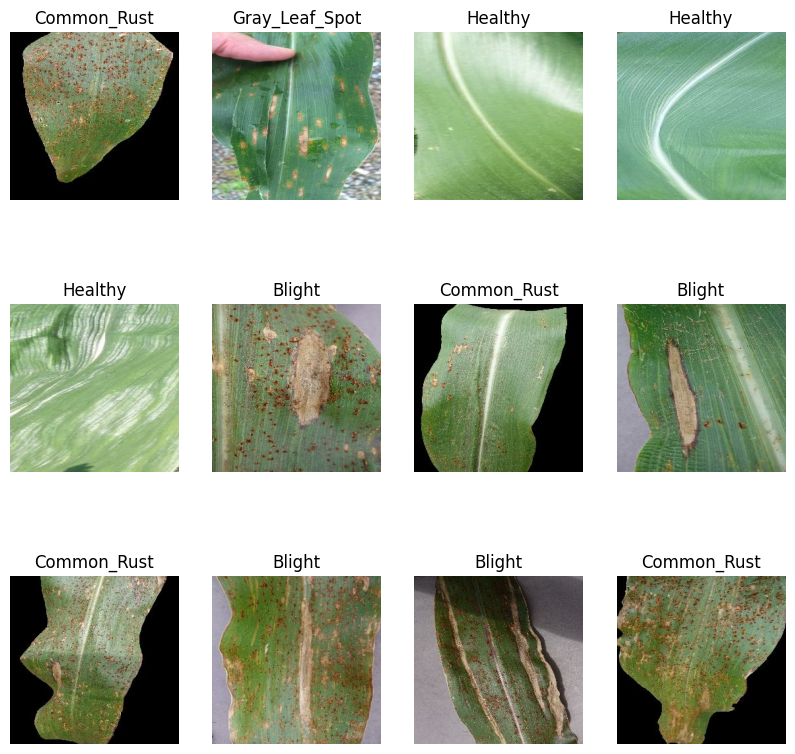

In [156]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")


In [157]:
len(dataset)

131

In [158]:
80% ==> training
20% ==> 10% validation, 10% test

SyntaxError: invalid syntax (829920516.py, line 1)

In [159]:
train_size = 0.8
len(dataset)*train_size

104.80000000000001

In [160]:
train_ds = dataset.take(104)
len(train_ds)

104

In [161]:
test_ds = dataset.skip(104)
len(test_ds)

27

In [162]:
val_size = 0.1
len(dataset)*val_size

13.100000000000001

In [163]:
val_ds = test_ds.take(6)
len(test_ds)

27

In [164]:
test_ds = test_ds.skip(6)
len(test_ds)

21

In [165]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [166]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [167]:
len(train_ds)

104

In [168]:
len(val_ds)

13

In [169]:
len(test_ds)

14

In [170]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [171]:
resize_and_rescale = tf.keras.Sequential([
  
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [172]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [108]:
# 1. Classes = 4 (Based on your first error)
n_classes = 4 

# 2. Input channels must be 3 (For RGB images)
# Your error shows your images are 500x500
IMAGE_SIZE = 500
CHANNELS = 3 

model = models.Sequential([
    # The '3' here represents RGB color channels
    layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    
    resize_and_rescale,
    data_augmentation,
    
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation= 'relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation= 'relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation= 'relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation= 'relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation= 'relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64, activation= 'relu'),
    
    # This is where the '4' belongs
    layers.Dense(n_classes, activation= 'softmax'),
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [109]:
#model.compile(
   # optimizer='adam',
    #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    #metrics=['accuracy']
#)

In [110]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data=val_ds
)

Epoch 1/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.5162 - loss: 0.9973 - val_accuracy: 0.6322 - val_loss: 0.8291
Epoch 2/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 96s 923ms/step - accuracy: 0.6790 - loss: 0.7235 - val_accuracy: 0.8293 - val_loss: 0.4805
Epoch 3/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.8144 - loss: 0.4561 - val_accuracy: 0.8029 - val_loss: 0.5260
Epoch 4/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.8369 - loss: 0.4042 - val_accuracy: 0.8317 - val_loss: 0.4452
Epoch 5/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.8469 - loss: 0.3830 - val_accuracy: 0.8341 - val_loss: 0.4362
Epoch 6/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.8604 - loss: 0.3522 - val_accuracy: 0.8678 - val_loss: 0.3489
Epoch 7/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 99s 957ms/step - accuracy: 0.8580 - loss: 0.3376 - val_accuracy: 0.8606 - val_loss: 0.3393
Epoch 8/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.8685 - loss: 0.3216 - val_

In [121]:
scores = model.evaluate(test_ds)

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - accuracy: 0.9464 - loss: 0.1484


In [122]:
scores

[0.14844031631946564, 0.9464285969734192]

In [123]:
history

In [124]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 104}

In [125]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [126]:
history.history['accuracy']

[0.5162454843521118,
 0.6790012121200562,
 0.8143802881240845,
 0.8369434475898743,
 0.8468712568283081,
 0.860409140586853,
 0.8580024242401123,
 0.8685318827629089,
 0.8682310581207275,
 0.862214207649231,
 0.8703369498252869,
 0.8715403079986572,
 0.8757520914077759,
 0.8862816095352173,
 0.8919975757598877,
 0.9010228514671326,
 0.895006000995636,
 0.8947051763534546,
 0.8904933929443359,
 0.887785792350769,
 0.9052346348762512,
 0.9007220268249512,
 0.9001203179359436,
 0.9022262096405029,
 0.9043321013450623,
 0.8664259910583496,
 0.8977136015892029,
 0.8944043517112732,
 0.9016245603561401,
 0.9103489518165588,
 0.9055355191230774,
 0.910649836063385,
 0.9124549031257629,
 0.9130565524101257,
 0.917870044708252,
 0.9196751117706299,
 0.9118531942367554,
 0.921480119228363,
 0.9229843616485596,
 0.9208784699440002,
 0.9190734028816223,
 0.9184716939926147,
 0.9241877198219299,
 0.9280986785888672,
 0.9220818281173706,
 0.9262936115264893,
 0.9166666865348816,
 0.9293020367622375,

In [127]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

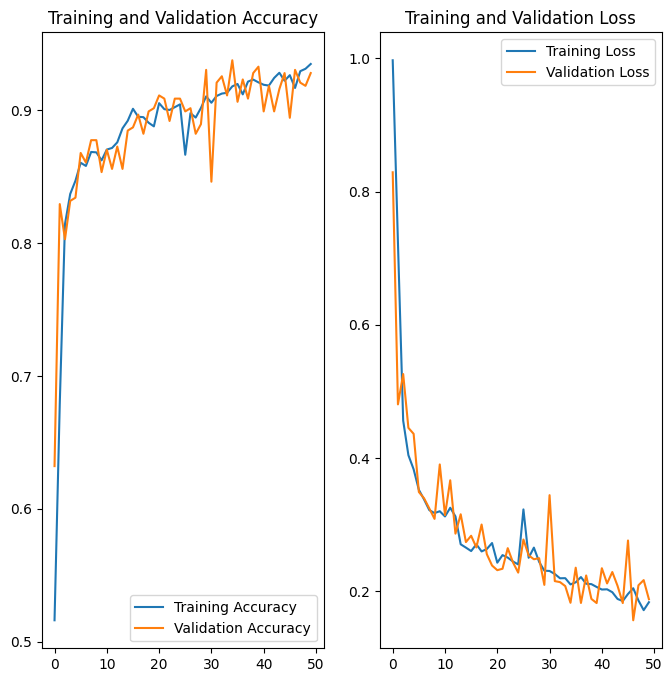

In [128]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
predicted label: Blight


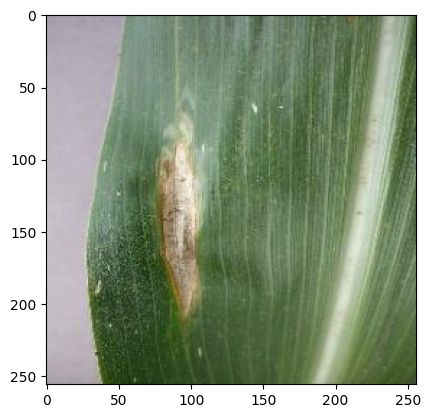

In [183]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    predicted_index = batch_prediction[0].argmax()
    print("predicted label:", class_names[predicted_index])

    

In [208]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array, verbose=0)

    predicted_index = int(tf.argmax(predictions[0]).numpy())
    predicted_class = class_names[predicted_index]
    confidence = round(float(tf.reduce_max(predictions[0]).numpy()) * 100, 2)

    return predicted_class, confidence


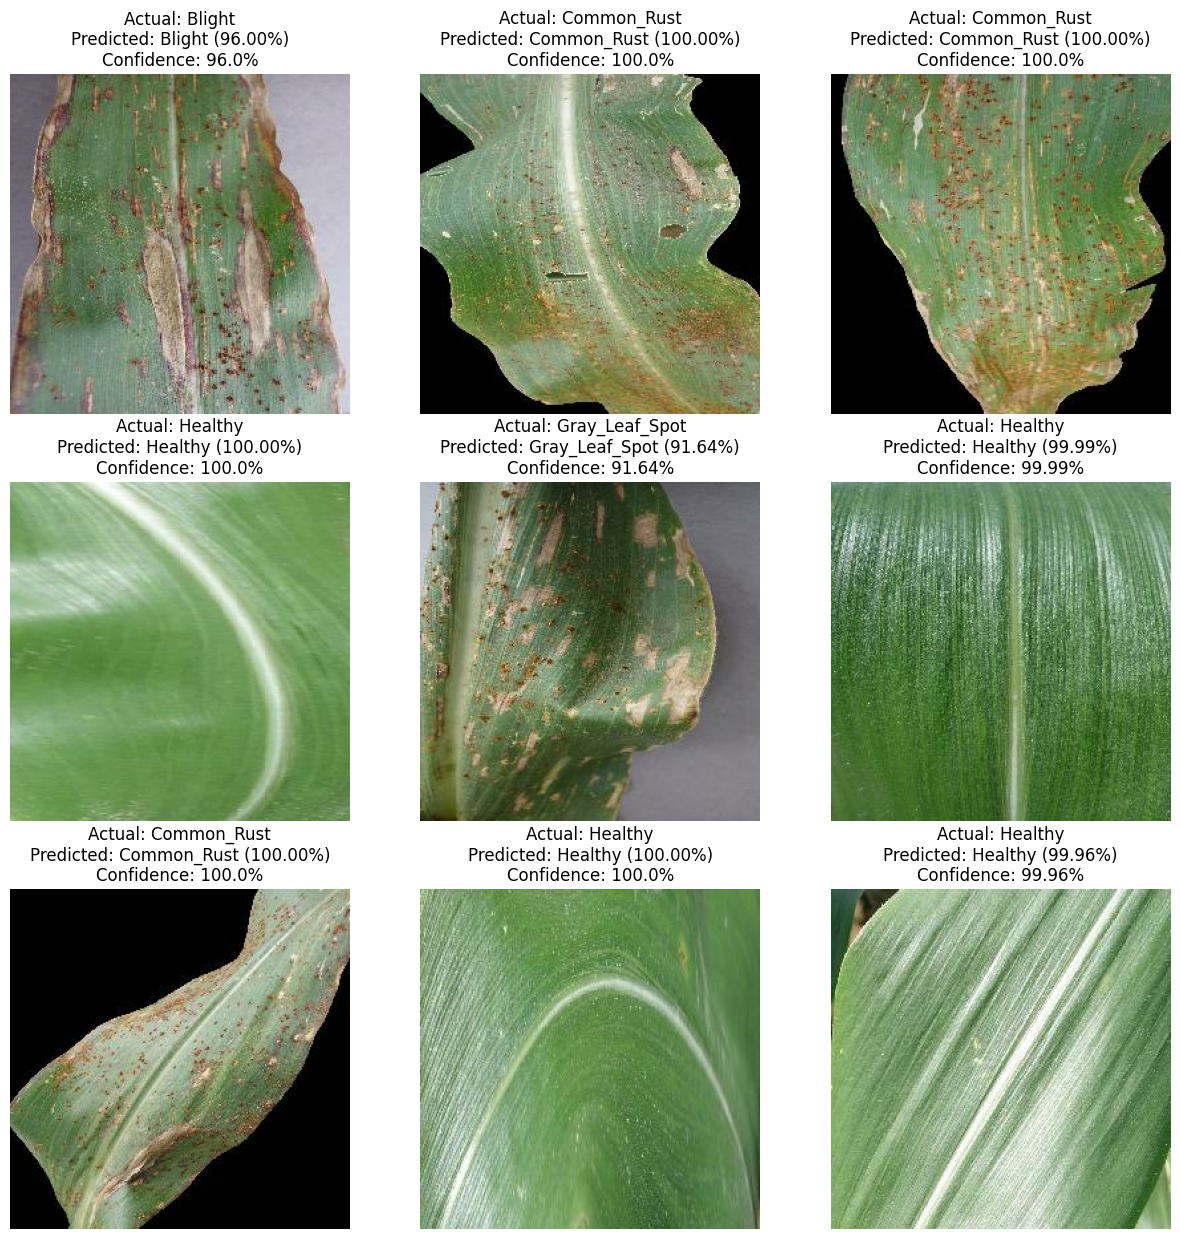

In [210]:
plt.figure(figsize=(15, 15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[int(labels[i])]

        plt.title(
            f"Actual: {actual_class}\n"
            f"Predicted: {predicted_class} ({confidence:.2f}%)\n"
            f"Confidence: {confidence}%"
        )
        plt.axis("off")


In [215]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.export(f"../models/{model_version}")


INFO:tensorflow:Assets written to: ../models/3\assets


INFO:tensorflow:Assets written to: ../models/3\assets


Saved artifact at '../models/3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 500, 500, 3), dtype=tf.float32, name='keras_tensor_24')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  2577805973776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2577604325264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2579159854800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2579159852112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2579159856720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2579159851728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2579159851920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2579159845200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2579159855184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2579159856528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2579159854992: TensorSpec(shape=(), 

In [214]:
model_version = 2
model.export(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets


Saved artifact at '../models/2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 500, 500, 3), dtype=tf.float32, name='keras_tensor_24')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  2577805973776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2577604325264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2579159854800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2579159852112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2579159856720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2579159851728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2579159851920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2579159845200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2579159855184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2579159856528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2579159854992: TensorSpec(shape=(), 